# Retroperitoneal sarcoma radiomics study
# Prediction of tumour type and grade
# Logistic regression with group selection

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500, 'display.max_rows', 500, 'display.precision', 3)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV
from sklearn.model_selection import cross_validate
import os, warnings, copy, sys, shutil
import matplotlib.pyplot as plt
import pickle
from time import strftime, localtime
from pyirr import intraclass_correlation
from scipy.stats import skew
import seaborn as sns
from scipy.stats import mannwhitneyu

rootFolder = os.path.join(os.path.expanduser("~"), 'Dicom Files/RADSARC_R')

# this module should be in the same folder as this notebook
from fit_LR_groupSelection_correlationThresholds import fit_LR_groupSelection_correlationThresholds, plotResultExperiments, displayOneExperiment

n_splits = 10
n_repeats = 1
thresholds = np.round(np.arange(0.6,1.00001,0.1), 2)
penalty = 'l1'

displayAll = True

## Create output and copy code

In [2]:
%%capture out_stream

# set output folder to None if this is a fresh run
# set output folder to an existing location to load pre-saved results from there
outputFolder = None #'/Users/morton/Dicom Files/RADSARC_R/XNAT/experiments/LR_GroupSelection__20220924_0958'

if outputFolder is None:
    
    saveOutputs = True
    
    outputFolder = os.path.join(rootFolder, 'XNAT/experiments/LR_GroupSelection__' + strftime("%Y%m%d_%H%M", localtime()))
    os.mkdir(outputFolder)
    os.mkdir(os.path.join(outputFolder, 'code'))
    os.mkdir(os.path.join(outputFolder, 'figures'))
    
    jupyterFile = os.path.join(os.path.abspath(""), 'LR_GroupSelection_withValidation.ipynb')
    shutil.copyfile(jupyterFile, os.path.join(outputFolder, 'code', 'LR_GroupSelection_withValidation.ipynb'))

    file1 = os.path.join(os.path.abspath(""), 'fit_LR_groupSelection_correlationThresholds.py')
    shutil.copyfile(file1, os.path.join(outputFolder, 'code', 'fit_LR_groupSelection_correlationThresholds.py'))

    user = os.path.expanduser("~")
    file2 = os.path.join(user, 'Documents/git/git_icrpythonradiomics/machineLearning/featureSelection.py')
    shutil.copyfile(file2, os.path.join(outputFolder, 'code', 'featureSelection.py'))

else:
    
    saveOutputs = False

### Utility functions

In [3]:
def groupStrsDisp(strGroups):
    
    def tidyGroup(strGroup):
        if strGroup == '':
            strGroup = 'all'
        strGroup = strGroup.replace('glcm|gldm|glszm|glrlm|ngtdm','texture')
        strGroup = strGroup.replace('firstorder|histogram','firstorder')
        return strGroup

    if isinstance(strGroups, str):
        return tidyGroup(strGroups)
    
    if isinstance(strGroups, list):
        return [tidyGroup(x) for x in strGroups]

## Load data

In [4]:
# open clinical spreadsheet
clinicalSpreadsheet = os.path.join(rootFolder, 'ClinicalData', 'Clinical data for analysis.xlsx')
dfClinical = pd.read_excel(clinicalSpreadsheet, sheet_name='220818_Completed segs', header = 2, skiprows=[3], nrows=170, engine='openpyxl')
dfClinical.sort_values('Anon Code', inplace=True, ignore_index=True)

# simplify grade
dfClinical['Grade_1_234'] = dfClinical['Grade']==1
dfClinical['Grade_12_34'] = dfClinical['Grade']<=2

# binarised outcome data
cutoffYears = 1.5
cutoffDays = cutoffYears*365

# There is an error in some of the rfs data in the spreadsheet, so re-compute it here.
# rfs = recurrence-free survival.  rfs = 1 if either arfs=1 (local recurrence) or dmfs=1 (distant recurrence)
# and t_rfs is the min of t_arfs and t_dmfs
dfClinical.drop(['rfs', 't_rfs'], inplace=True, axis=1)
dfClinical['rfs'] = np.logical_or(dfClinical['arfs']==1, dfClinical['dmfs']==1).astype(int)
dfClinical['t_rfs'] = dfClinical[['t_arfs', 't_dmfs']].min(axis=1)

def binarizeOutcome(df, new_val1, new_val2, old_val2, feat_time, feat_event, new_feat_name):

    df[new_feat_name] = new_val1
    df.loc[df[feat_time] >= cutoffDays, new_feat_name] = new_val2
    df.loc[np.logical_and(df[feat_time] < cutoffDays, df[feat_event] == old_val2), new_feat_name] = 'Unknown'

binarizeOutcome(dfClinical, 'Dead', 'Alive', 'Alive', 't_os', 'os', 'os_cutoff')
binarizeOutcome(dfClinical, 'Yes', 'No', 0, 't_dmfs', 'dmfs', 'distant_cutoff')
binarizeOutcome(dfClinical, 'Yes', 'No', 0, 't_arfs', 'arfs', 'local_cutoff')
binarizeOutcome(dfClinical, 'Yes', 'No', 0, 't_rfs', 'rfs', 'recurrence_cutoff')

dfClinical = dfClinical[['Anon Code', 
                         'Grade_1_234', 
                         'Grade_12_34', 
                         'subtype', 
                         'os_cutoff', 
                         'distant_cutoff',
                         'local_cutoff',
                         'recurrence_cutoff']]


# TEST open clinical spreadsheet
clinicalSpreadsheetTest = os.path.join(rootFolder, 'ClinicalData', 'EORTC_Radsarc_Clindata.xlsx')
dfClinicalTest = pd.read_excel(clinicalSpreadsheetTest, sheet_name='Completed segs_for analysis', engine='openpyxl')
dfClinicalTest['Anon Code'] = ['EORTCRSRC_' + str(int(x)).zfill(3) for x in dfClinicalTest['PATID']]

# simplify grade
dfClinicalTest['Grade_1_234'] = dfClinicalTest['grade']==1
dfClinicalTest['Grade_12_34'] = dfClinicalTest['grade']<=2

# make rfs data

dfClinicalTest['rfs'] = np.logical_or(dfClinicalTest['arfs2']==1, dfClinicalTest['dmfs']==1).astype(int)
dfClinicalTest['t_rfs'] = dfClinicalTest[['t_arfs2', 't_dmfs']].min(axis=1)

# binarised outcome data
binarizeOutcome(dfClinicalTest, 'Dead', 'Alive', 1, 't_ss', 'ss', 'os_cutoff')
binarizeOutcome(dfClinicalTest, 'Yes', 'No', 1, 't_dmfs', 'dmfs', 'distant_cutoff')
binarizeOutcome(dfClinicalTest, 'Yes', 'No', 1, 't_arfs2', 'arfs2', 'local_cutoff')
binarizeOutcome(dfClinicalTest, 'Yes', 'No', 1, 't_rfs', 'rfs', 'recurrence_cutoff')

dfClinicalTest = dfClinicalTest[['Anon Code', 
                                 'Grade_1_234', 
                                 'Grade_12_34', 
                                 'subtype',
                                 'os_cutoff', 
                                 'distant_cutoff',
                                 'local_cutoff',
                                 'recurrence_cutoff']]


In [5]:
def readRadData(folder):
    df = pd.read_csv(os.path.join(rootFolder, 'XNAT', 'extractions', folder, 'radiomicFeatures', 'radiomicFeatures.csv'))
    df.drop(list(df.filter(regex = 'source')), axis = 1, inplace = True)
    df.drop(list(df.filter(regex = 'diagnostic')), axis = 1, inplace = True)
    df.drop(list(df.filter(regex = 'histogram')), axis = 1, inplace = True)
    return df

# training
dfRad = readRadData('extractions__20221122_1628_allRegions_volFracApprox')

# reproducibility
dfRadRep = readRadData('extractions__20221122_2037_repro_volFracApprox')

# open test data
dfRadTest = readRadData('extractions__20221125_0939_eortcTestData')

## Compute ICCs and remove unreproducible features

In [6]:
dfRadOri = dfRad.copy()

subjectIDs = dfRadOri.merge(dfRadRep, on='StudyPatientName').StudyPatientName

# select rows and make sure they are both sorted on SubjectID
dfRadOri = dfRadOri.loc[dfRadOri['StudyPatientName'].isin(subjectIDs)]
dfRadOri.sort_values('StudyPatientName', axis=0, inplace=True)

dfRadRep = dfRadRep.loc[dfRadRep['StudyPatientName'].isin(subjectIDs)]
dfRadRep.sort_values('StudyPatientName', axis=0, inplace=True)

# remove high/mid/low_enhancing features
dfRadOri.drop(list(dfRadOri.filter(regex = 'low_enhancing_original')), axis = 1, inplace = True)
dfRadRep.drop(list(dfRadRep.filter(regex = 'low_enhancing_original')), axis = 1, inplace = True)
dfRadOri.drop(list(dfRadOri.filter(regex = 'mid_enhancing_original')), axis = 1, inplace = True)
dfRadRep.drop(list(dfRadRep.filter(regex = 'mid_enhancing_original')), axis = 1, inplace = True)
dfRadOri.drop(list(dfRadOri.filter(regex = 'high_enhancing_original')), axis = 1, inplace = True)
dfRadRep.drop(list(dfRadRep.filter(regex = 'high_enhancing_original')), axis = 1, inplace = True)

# remove these features
dfRadOri.drop(list(dfRadOri.filter(regex = 'calcificationDeleted')), axis = 1, inplace = True)
dfRadRep.drop(list(dfRadRep.filter(regex = 'calcificationDeleted')), axis = 1, inplace = True)

dfRadOri.reset_index(inplace=True)
dfRadRep.reset_index(inplace=True)

iccValues = []
featNames = []
for col in dfRadOri.columns:
    if col == 'StudyPatientName' or col=='index':
        continue
    data = np.stack((dfRadOri[col], dfRadRep[col]), axis=1)
    featNames.append(col)
    iccValues.append(intraclass_correlation(data, "twoway", "agreement").value)
iccDf = pd.DataFrame({'Feature':featNames, 'ICC':iccValues})

iccThreshold = 0.75

reproducibleFeatures = list(iccDf.Feature[iccDf.ICC>iccThreshold])
reproducibleFeatures.append('StudyPatientName')

dfRad = dfRad.filter(reproducibleFeatures)
dfRadTest = dfRadTest.filter(reproducibleFeatures)

## Log transform positive skewed parameters

In [7]:
def makeLog(df, feat, offset=0):
    df[feat+'_log'] = np.log(df[feat]+offset)
    df.drop(feat, axis=1, inplace=True)
    return df

for feat in dfRad.filter(regex='lesion_original', axis=1).columns:
    if skew(dfRad[feat])>3 and np.all(dfRad[feat]>0):
        dfRad = makeLog(dfRad, feat)
        dfRadTest = makeLog(dfRadTest, feat)

# this is heavily skewed, but has minimum value -87
dfRad = makeLog(dfRad, 'lesion_original_glcm_ClusterShade', offset=90)
dfRadTest = makeLog(dfRadTest, 'lesion_original_glcm_ClusterShade', offset=90)

In [8]:
def featureClassDensities(df_Train, df_Test, featureClass, spSize):
    f,a = plt.subplots(spSize[0], spSize[1], figsize=(20,12))
    a = a.ravel()
    for n, feat in enumerate(df_Train.filter(regex = featureClass, axis = 1).columns):
        df1 = pd.DataFrame(df_Train[feat].copy())
        df1['Data'] = 'train'
        df2 = pd.DataFrame(df_Test[feat].copy())
        df2['Data'] = 'test'
        dfPlot = pd.concat([df1, df2])
        dfPlot.reset_index(drop=True, inplace=True)
        featPlot = feat.replace('lesion_original_' + featureClass + '_','')
        dfPlot.rename(columns={feat:featPlot}, inplace=True)
        sns.kdeplot(data=dfPlot, x=featPlot, hue='Data', ax = a[n], common_grid=True, common_norm=False)

if False:
    featureClassDensities(dfRad.filter(regex='lesion_original'), dfRadTest.filter(regex='lesion_original'), 'shape', (3, 5))
    featureClassDensities(dfRad.filter(regex='lesion_original'), dfRadTest.filter(regex='lesion_original'), 'firstorder', (3,6))
    featureClassDensities(dfRad.filter(regex='lesion_original'), dfRadTest.filter(regex='lesion_original'), 'glcm', (4,6))
    featureClassDensities(dfRad.filter(regex='lesion_original'), dfRadTest.filter(regex='lesion_original'), 'glrlm', (4,4))
    featureClassDensities(dfRad.filter(regex='lesion_original'), dfRadTest.filter(regex='lesion_original'), 'glszm', (4,4))
    featureClassDensities(dfRad.filter(regex='lesion_original'), dfRadTest.filter(regex='lesion_original'), 'gldm', (3,5))
    featureClassDensities(dfRad.filter(regex='lesion_original'), dfRadTest.filter(regex='lesion_original'), 'ngtdm', (2,3))


## Select targets

In [9]:
# targets = ['subtype', 'Grade_1_234', 'Grade_12_34']
targets = ['os_cutoff', 'distant_cutoff', 'local_cutoff', 'recurrence_cutoff']

## Run classifications

In [10]:
def prepData(dfC, dfR, target, featureSet, removeTargetUnknown=True):
    df = dfC.merge(dfR, left_on='Anon Code', right_on='StudyPatientName')
    df.drop('Anon Code', axis=1, inplace=True)
    df.drop('StudyPatientName', axis=1, inplace=True)
    df = df.filter(regex=featureSet + '|' + target)
    if removeTargetUnknown:
        df = df.loc[df[target] != 'Unknown',:]
    return df

def fitModelOrLoadSaved(df, target, settings, qlf):
    
    if os.path.exists(qlf):
        with open(qlf, 'rb') as handle:
            result = pickle.load(handle)
    else:
        result = fit_LR_groupSelection_correlationThresholds(df, target, settings)

        if saveOutputs:
            with open(qlf, 'wb') as handle:
                pickle.dump(result, handle)

    return copy.deepcopy(result)

def showTrainTestResults(result):
    
    # find best model i.e. across all thresholds
    AUROC_cv = np.array([np.mean(x['cv_result']['test_score']) for x in result['experiments']])
    idx = np.argmax(AUROC_cv)
    bestExperiment = result['experiments'][idx]

    trainScore = bestExperiment['model'].predict_proba(df.drop(target, axis=1))
    testScore = bestExperiment['model'].predict_proba(dfTest.drop(target, axis=1))
    
    # get p-value on test data
    classLabels = list(set(dfTest[target]))
    testScores0 = testScore[dfTest[target]==classLabels[0],1]
    testScores1 = testScore[dfTest[target]==classLabels[1],1]
    _, pValue = mannwhitneyu(testScores0, testScores1, alternative='two-sided')
    
    print('AUC')
    print('train #      = ' + str(np.sum(df[target]==classLabels[0])) + ' : ' + str(np.sum(df[target]==classLabels[1])))
    print('train resub  = ' + str(np.round(roc_auc_score(df[target], trainScore[:,1]),3)))
    print('train CV     = ' + str(np.round(np.mean(bestExperiment['cv_result']['test_score']),3)))
    print('\n')
    print('test #       = ' + str(np.sum(dfTest[target]==classLabels[0])) + ' : ' + str(np.sum(dfTest[target]==classLabels[1])))
    print('test         = ' + str(np.round(roc_auc_score(dfTest[target], testScore[:,1]),3)))
    print('test p-value = ' + str(np.round(pValue,4)))
    print('\n')
    

defaultSettings = {'n_splits':n_splits, 
                   'n_repeats':n_repeats,
                   'thresholds':thresholds,
                   'penalty':penalty
                   }

### Standard radiomics features

os_cutoff_os_cutoff_os_cutoff_os_cutoff_os_cutoff_os_cutoff_os_cutoff_os_cutoff_os_cutoff_os_cutoff_

Threshold = 0.6
shape
AUROC = 0.459 ± 0.154

Threshold = 0.7
firstorder
AUROC = 0.598 ± 0.1394

Threshold = 0.8
firstorder
AUROC = 0.551 ± 0.1298

Threshold = 0.9
firstorder
AUROC = 0.545 ± 0.1312

Threshold = 1.0
shape|firstorder
AUROC = 0.585 ± 0.1486



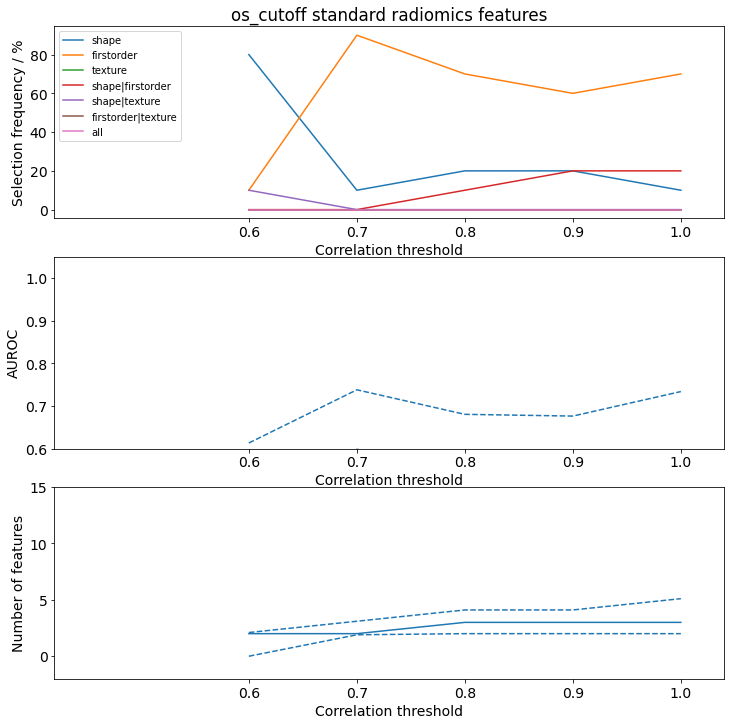

Threshold = 0.7
AUROC (CV) = 0.5984

Feature group = firstorder



Feature,Frequency,Coef
lesion_original_firstorder_90Percentile,60.000,0.806
lesion_original_firstorder_InterquartileRange,40.000,-0.058



os_cutoff
AUC
train #      = 125 : 23
train resub  = 0.706
train CV     = 0.598


test #       = 82 : 5
test         = 0.578
test p-value = 0.5656


distant_cutoff_distant_cutoff_distant_cutoff_distant_cutoff_distant_cutoff_distant_cutoff_distant_cutoff_distant_cutoff_distant_cutoff_distant_cutoff_

Threshold = 0.6
shape
AUROC = 0.611 ± 0.1741

Threshold = 0.7
shape|firstorder
AUROC = 0.724 ± 0.1582

Threshold = 0.8
shape|firstorder
AUROC = 0.718 ± 0.1515

Threshold = 0.9
shape|firstorder
AUROC = 0.733 ± 0.127

Threshold = 1.0
shape|firstorder
AUROC = 0.764 ± 0.127



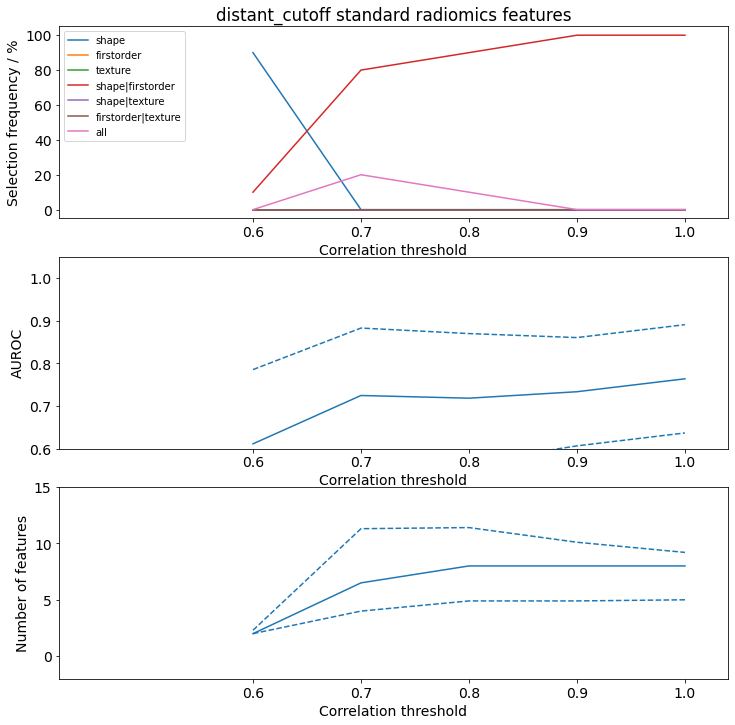

Threshold = 1.0
AUROC (CV) = 0.76364

Feature group = shape|firstorder



Feature,Frequency,Coef
lesion_original_shape_Sphericity,100.000,-0.779
lesion_original_firstorder_Mean,100.000,1.002
lesion_original_shape_Flatness,90.000,0.180
lesion_original_firstorder_Kurtosis_log,90.000,-0.145
lesion_original_shape_Elongation,80.000,0.126
lesion_original_firstorder_10Percentile,70.000,0.294
lesion_original_firstorder_Range,50.000,0.091
lesion_original_shape_Maximum2DDiameterSlice,40.000,0.002
lesion_original_firstorder_Median,40.000,0.084



distant_cutoff
AUC
train #      = 111 : 31
train resub  = 0.823
train CV     = 0.764


test #       = 75 : 12
test         = 0.559
test p-value = 0.5181


local_cutoff_local_cutoff_local_cutoff_local_cutoff_local_cutoff_local_cutoff_local_cutoff_local_cutoff_local_cutoff_local_cutoff_



In [ ]:
if True:

    resultStandard = {}
    
    for target in targets:
        
        print((target + '_')*10 + '\n')
        
        featureSet = 'lesion_original'

        df = prepData(dfClinical, dfRad, target, featureSet)
        dfTest = prepData(dfClinicalTest, dfRadTest, target, featureSet)
        
        settings = defaultSettings.copy()
        textureStr = 'glcm|gldm|glszm|glrlm|ngtdm'
        settings['groupHierarchy'] = ['shape',
                                      'firstorder',
                                      textureStr,
                                      'shape|firstorder',
                                      'shape|' + textureStr,
                                      'firstorder|' + textureStr,
                                      '']

        quickLoadFile = os.path.join(outputFolder, 'LR_GroupSelection_Standard_' + target + '.pickle')

        resultStandard[target] = fitModelOrLoadSaved(df, target, settings, quickLoadFile)

        if displayAll:
            plotResultExperiments(resultStandard[target], 
                                  titleStr=target + ' standard radiomics features',
                                  outputFile=os.path.join(outputFolder, 'figures', target + '_standard.pdf'))

            bestCoef, pdFreq = displayOneExperiment(resultStandard[target])
            pdFreq = pdFreq.loc[pdFreq.Coef!='',:] # trim off any coeff that aren't in the best model
            display(pdFreq.style.hide_index())

        print('\n'+target)
        showTrainTestResults(resultStandard[target])

### Volume fraction and standard radiomics features

In [ ]:
if True:
    
    resultVolFrac = {}
    
    for target in targets:

        print((target + '_')*10 + '\n')
        
        featureSet = 'lesion_original|VolumeFraction'

        df = prepData(dfClinical, dfRad, target, featureSet)
        dfTest = prepData(dfClinicalTest, dfRadTest, target, featureSet)
        
        # remove one of the volume fraction features as it is co-linear with the others
        df.drop('lesion_sarcomaFeature_mid enhancingVolumeFraction', axis=1, inplace=True)
        dfTest.drop('lesion_sarcomaFeature_mid enhancingVolumeFraction', axis=1, inplace=True)

        settings = defaultSettings.copy()
        textureStr = 'glcm|gldm|glszm|glrlm|ngtdm'
        settings['groupHierarchy'] = ['VolumeFraction',
                                      'shape',
                                      'firstorder',
                                      textureStr,
                                      'VolumeFraction|shape',
                                      'VolumeFraction|firstorder',
                                      'VolumeFraction|' + textureStr,
                                      'shape|firstorder',
                                      'shape|' + textureStr,
                                      'firstorder|' + textureStr,
                                      '']
        settings['correlationHierarchy'] = ['VolumeFraction', 'shape', 'firstorder']

        
        quickLoadFile = os.path.join(outputFolder, 'LR_GroupSelection_VolumeFractions_' + target + '.pickle')

        resultVolFrac[target] = fitModelOrLoadSaved(df, target, settings, quickLoadFile)

        if displayAll:
            plotResultExperiments(resultVolFrac[target], 
                                  titleStr = target + ' volume fraction + standard radiomics features',
                                  outputFile=os.path.join(outputFolder, 'figures', target+'_standard_volFrac.pdf'))


            bestCoef, pdFreq = displayOneExperiment(resultVolFrac[target])
            pdFreq = pdFreq.loc[pdFreq.Coef!='',:] # trim off any coeff that aren't in the best model
            display(pdFreq.style.hide_index())

        print('\n'+target)
        showTrainTestResults(resultVolFrac[target])

### Approx volume fraction and standard radiomics features

In [ ]:
if True:
    
    resultApproxVolFrac = {}
    
    for target in targets:

        print((target + '_')*5 + '\n')
        
        featureSet = 'lesion_original|ApproxVolFraction'

        df = prepData(dfClinical, dfRad, target, featureSet)
        dfTest = prepData(dfClinicalTest, dfRadTest, target, featureSet)

        settings = defaultSettings.copy()
        textureStr = 'glcm|gldm|glszm|glrlm|ngtdm'
        settings['groupHierarchy'] = ['ApproxVolFraction',
                                      'shape',
                                      'firstorder',
                                      textureStr,
                                      'ApproxVolFraction|shape',
                                      'ApproxVolFraction|firstorder',
                                      'ApproxVolFraction|' + textureStr,
                                      'shape|firstorder',
                                      'shape|' + textureStr,
                                      'firstorder|' + textureStr,
                                      '']
        settings['correlationHierarchy'] = ['ApproxVolFraction', 'shape', 'firstorder']
        
        quickLoadFile = os.path.join(outputFolder, 'LR_GroupSelection_ApproxVolFraction_' + target + '.pickle')

        resultApproxVolFrac[target] = fitModelOrLoadSaved(df, target, settings, quickLoadFile)

        if displayAll:
            plotResultExperiments(resultApproxVolFrac[target], 
                                  titleStr = target + ' approx volume fraction + standard radiomics features',
                                  outputFile=os.path.join(outputFolder, 'figures', target+'_approx_volFrac.pdf'))


            bestCoef, pdFreq = displayOneExperiment(resultApproxVolFrac[target])
            pdFreq = pdFreq.loc[pdFreq.Coef!='',:] # trim off any coeff that aren't in the best model
            display(pdFreq.style.hide_index())

        print('\n'+target)
        showTrainTestResults(resultApproxVolFrac[target])

## Re-save the copy of this notebook once it is completed

In [ ]:
from IPython.display import display, Javascript
import time

# save current state of notebook and wait a bit as the actual save happens with a short delay
display(Javascript('IPython.notebook.save_checkpoint();'))
time.sleep(10)

# copy notebook to output folder
if saveOutputs:
    jupyterFile = os.path.join(os.path.abspath(""), 'LR_GroupSelection_withValidation.ipynb')
    shutil.copyfile(jupyterFile, os.path.join(outputFolder, 'code', 'LR_GroupSelection_withValidation.ipynb'))